<H1 style="font-size:50px">11: Metodo Monte Carlo</H1>

Introduzione
------------
Il Metodo Monte Carlo si riferisce a un insieme di tecniche di calcolo e simulazione che si basano sull'uso di numeri casuali.

## 11.1 Integrazione numerica con metodo MC

L'idea di usare numeri casuali per calcolare un integrale numerico si basa sul teorema della media in Analisi che afferma che l'integrale  $\int_a^b f(x)\,dx$ è uguale al prodotto della lunghezza (con segno) dell'intervallo di integrazione $(b-a)$ per il valor medio della funzione $f$, $<f>$, nell'intervallo. Il valor medio può essere calcolato
facendo la media dei valori di $f$ in un set di punti scelti a caso in $[a,b]$.<BR>
Esempio: $\int_1^2 x^2 dx = \frac{7}{3}$<BR>   

In [22]:
import numpy as np
from numpy.random import default_rng

rng = default_rng()

npoints=10
xval=rng.uniform(size=npoints)+1.   #punti casuali in [1,2]
#print(xval)

y_ave=np.mean(xval*xval)
my_int=y_ave*(2.-1.)
print("Stima dell'integrale:",my_int)
print("Risultato esatto:",7/3)

Stima dell'integrale: 2.520720064255817
Risultato esatto: 2.3333333333333335


Aumentiamo il numero di punti:

In [24]:
npoints=100
xval=rng.uniform(size=npoints)+1.   #punti casuali in [1,2]
#print(xval)

y_ave=np.mean(xval*xval)
my_int=y_ave*(2.-1.)
print("Stima dell'integrale:",my_int)
print("Risultato esatto:",7/3)

Stima dell'integrale: 2.2300646377312843
Risultato esatto: 2.3333333333333335


In [30]:
npoints=1000
xval=rng.uniform(size=npoints)+1.   #punti casuali in [1,2]
#print(xval)

y_ave=np.mean(xval*xval)
my_int=y_ave*(2.-1.)
print("Stima dell'integrale:",my_int)
print("Risultato esatto:",7/3)

Stima dell'integrale: 2.3142078477545596
Risultato esatto: 2.3333333333333335


Confrontate il risultato con quello fornito dal metodo dei trapezi e da `quad` nel notebook 10_scipy.

Esempio in più dimensioni: il volume di una semisfera di raggio 1: 
$$\int_{-1}^1 dx \int_{-\sqrt{1-x^2}}^{\sqrt{1-x^2}}dy\,\sqrt{1-x^2-y^2} = \frac{2}{3}\pi$$

In [33]:
#npoints = 100
npoints = 10000
xval=2*rng.uniform(size=npoints)-1.
#print(xval)
yval=2*rng.uniform(size=npoints)-1.
#print(yval)
points=[pair for pair in zip(xval,yval) if pair[0]**2 + pair[1]**2 < 1.] #zip returns tuples
points=np.array(points)
#type(points)
#len(points)
#print(points)

In [34]:
def my_f(point):
    return np.sqrt(1.- (point*point).sum(axis=1)).mean()

base_area=np.pi
print("Stima dell'integrale:",base_area*my_f(points))
print("Risultato esatto:",2/3*np.pi)

Stima dell'integrale: 2.099909570041918
Risultato esatto: 2.0943951023931953


Il grande vantaggio del metodo Monte Carlo è che si può estendere immediatamente a qualunque numero di dimensioni.

## 11.2 Generazione di eventi distribuiti secondo una densità di probabilità fissata

### Metodo hit and miss


Supponiamo di avere la seguente distribuzione di probabilità:
$$P(x) = \begin{cases} 0.6 \quad x<0.5\\ 1.7 \quad x>0.5 \end{cases}$$

<div style= 'padding:20px 20px 20px 150px;'>
  <img src="../Images/stepprobability.png" width="300" />
</div>

e di voler generare valori di $x$ distribuiti secondo $P(x)$

Procediamo nel modo seguente:

- Troviamo un numero $Y$ tale che $P(x) < Y, \,\forall x$. Nel nostro caso potremmo prendere $Y = 2$, per esempio.  
- Generiamo un numero casuale $x_0$ in [0,1], in modo uniforme.
- Generiamo un secondo numero casuale $y_0$ in [0,$Y$]
- Teniamo il numero $x_0$ nel sample se $y_0 < P(x_0)$ altrimenti lo scartiamo e generiamo un nuovo valore $x_0$.

La probabilità di tenere un punto nel bin di sinistra è:
$$P_{sx}=P(x < 0.5)\cdot P(y < 0.6) = 0.5\cdot\frac{0.6}{2}$$
La probabilità di tenere un punto nel bin di destra è:
$$P_{dx}=P(x > 0.5)\cdot P(y < 1.7) = 0.5\cdot\frac{1.4}{2}$$
Quindi il rapporto $R$ fra le due probabilità, ovvero il rapporto fra il numero di punti accettati in $x < 0.5$ e il numero di punti accettati in $x > 0.5$ è, come deve:
$$ R = \frac{P_{sx}}{P_{dx}} = \frac{0.6}{1.7}$$

In [14]:
npoints=1000
# npoints = 1000000
xval=rng.uniform(size=npoints)
# Separo i valori minori/maggiori di 0.5
x1val=[x for x in xval if x < 0.5]
x2val=[x for x in xval if x > 0.5]

y1=0.6
y2=1.4

x1val=[x for x in x1val if y1 > rng.uniform()*2]
x2val=[x for x in x2val if y2 > rng.uniform()*2]

print("Numero di punti in [0,0.5]:",len(x1val))
print("Numero di punti in [0.5,1]:",len(x2val))
print("rapporto fra i numeri di punti:",len(x2val)/len(x1val),"rapporto atteso=7/3:",7/3)

Numero di punti in [0,0.5]: 136
Numero di punti in [0.5,1]: 362
rapporto fra i numeri di punti: 2.661764705882353 rapporto atteso=7/3: 2.3333333333333335


### Test della generazione Monte Carlo di punti secondo una distribuzione data

#### Una funzione generica per generare eventi secondo una distribuzione qualsiasi

In [15]:
import numpy as np

def generate_f(f,a,b,max):
    '''
    Generate random points distributed according to an input distribution
    Input:
    f: the probability distribution
    a,b: extrema of the range for the desired random number
    max: a real number such that f(x) < max for each x
    Returns:
    ranval: random number
    '''
    not_found=True
    while not_found:
        x=rng.uniform(a,b)
        y=rng.uniform(0,max)
        if f(x)>y:
            not_found=False
    
    return x
    

#### Esempio 1

In [16]:
def f1(x):
    if x < 0.5:
        val=0.6
    else:
        val=1.4
    
    return val
    

In [17]:
#npoints=1000
npoints = 1000000
xval = [generate_f(f1,0,1,2) for n in range(npoints)]
x1val=[x for x in xval if x < 0.5]
x2val=[x for x in xval if x > 0.5]

print("Numero di punti in [0,0.5]:",len(x1val))
print("Numero di punti in [0.5,1]:",len(x2val))
print("rapporto fra i numeri di punti:",len(x2val)/len(x1val),"rapporto atteso=7/3:",7/3)

Numero di punti in [0,0.5]: 300661
Numero di punti in [0.5,1]: 699339
rapporto fra i numeri di punti: 2.3260050355716237 rapporto atteso=7/3: 2.3333333333333335


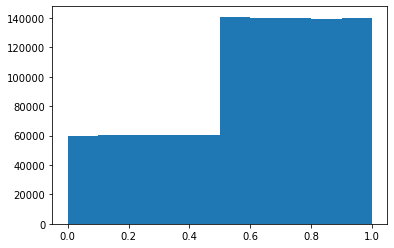

In [18]:
import matplotlib.pyplot as plt
nbins = 10
xrange = (0,1)

fig, ax = plt.subplots()
nevent, bins, patches = ax.hist(xval, nbins, range=xrange)

#### Esempio 2

In [9]:
def f2(x):
    val=3./8.*(1+x**2)
    
    return val    

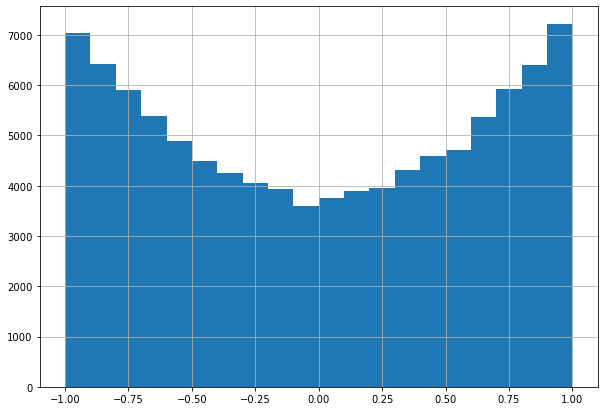

In [11]:
#npoints=1000
npoints = 100000
xval = [generate_f(f2,-1,1,1) for n in range(npoints)]

nbins = 20
xrange = (-1,1)

fig, ax = plt.subplots(figsize=(10,7))
nevent, bins, patches = ax.hist(xval, nbins, range=xrange)
ax.grid(True)

## 11.3 Propagazione dell'errore con metodo MC

Supponiamo di aver fatto un esperimento per misurare l'accelerazione di gravità $g$ misurando il periodo $T$ di oscillazione di un pendolo di lunghezza variabile $L$. Sappiamo che:
$$ T = 2 \pi \sqrt{\frac{L}{g}} \quad \rightarrow \quad g = \frac{ 4 \pi^2 L}{T^2}$$
Supponiamo di aver misurato $L = 1.000 \pm 0.004\, m$, $T = 2.000 \pm 0.005\, s$ e che le misure siano distribuite gaussianamente.
Per la propagazine degli errori ci servono:
$$ \frac{\partial g}{\partial T} = \frac{ - 8 \pi^2 L}{T^3},\qquad  \frac{\partial g}{\partial L} = \frac{ 4 \pi^2}{T^2}$$

$$ \sigma_g = \sqrt{\left. \sigma_T \, \frac{\partial g}{\partial T}\right|^2_{\overline{T},\overline{L}} +
\left. \sigma_L \, \frac{\partial g}{\partial L}\right|^2_{\overline{T},\overline{L}}
}$$

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def g(L,T):
    return 4*np.pi**2*L/T**2

def g_err(L,L_err,T,T_err):
    return 4*np.pi**2/T**2*np.sqrt(4*(L/T*T_err)**2 + L_err**2)

L_mean =1.0
L_err = 0.004
T_mean = 2.0
T_err = 0.005

g_m = g(L_mean,T_mean)
g_e = g_err(L_mean,L_err,T_mean,T_err)
print(f"g_exp = {g_m} +\- {g_e}")

g_exp = 9.869604401089358 +\- 0.06319630315448918


Per valutare l'errore su $g$ con il metodo Monte Carlo generiamo 1000 valori per L e 1000 per T da distribuzioni gaussiane con i rispettivi valori medi e deviazioni standard. Calcoliamo i corrispondenti valori di $g$ e valutiamo il valor medio e la deviazione standard della distribuzione ottenuta.

In [20]:
npoints = 1000
T_test = rng.normal(T_mean,T_err,npoints)
L_test = rng.normal(L_mean,L_err,npoints)
g_test = g(L_test,T_test)
g_m1 = g_test.mean()
g_e1 = g_test.std()
print(f"g_MC = {g_m1} +\- {g_e1}")

g_MC = 9.867338107189237 +\- 0.06329906777231029


### Plot di controllo

Nota sulle normalizzazioni:<BR>
    - Dato un istogramma con $N_{tot}$ valori, i valori in ciascun bin sommano a $N_{tot}$.    
    - Se si vuole sovrapporre una gaussiana $g(x)$ all'istogramma bisogna ricordare che: $\int g(x)\,dx = \sum_i g(x_i) w =1$, dove $w$ è la larghezza di ciascun bin. Di conseguenza i valori di $g(x)$ vanno moltiplicati per $w \cdot N_{tot}$ per avere un confronto significativo.

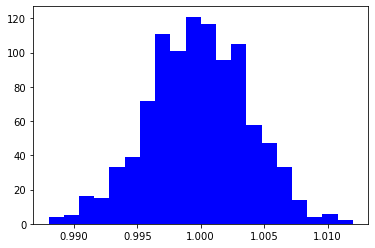

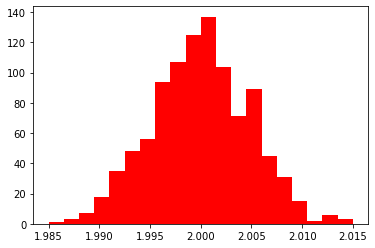

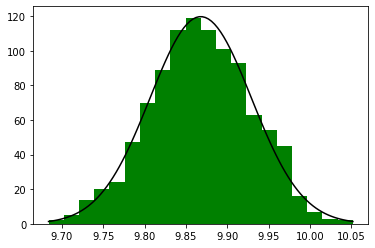

In [68]:
def Gauss_dist(t,lam,sigma):
    return np.exp(-0.5*((t-lam)/sigma)**2)/np.sqrt(2*np.pi)/sigma

fig1, ax1 = plt.subplots()

nbins = 20
range1 = (L_mean - 3*L_err,L_mean + 3*L_err)
ax1.hist(L_test,nbins,range1,color='b',label='L');

fig2, ax2 = plt.subplots()

nbins = 20
range2 = (T_mean - 3*T_err,T_mean + 3*T_err)
ax2.hist(T_test,nbins,range2,color='r',label='T');


fig3, ax3 = plt.subplots()

nbins = 20
range3 = (g_m1 - 3*g_e1,g_m1 + 3*g_e1)
binwidth = 6*g_e1/nbins

ax3.hist(g_test,nbins,range3,color='g',label='g');

t = np.linspace(g_m1 - 3*g_e1,g_m1 + 3*g_e1,100)
yval = Gauss_dist(t,g_m1,g_e1)*npoints*binwidth
#yval = np.array([np.exp(-0.5*((t1-g_m1)/g_e1)**2)/np.sqrt(2*np.pi)/g_e1 for t1 in t])
#print(yval)

ax3.plot(t,yval,c='k')


## 11.4 Simulazione di eventi complessi con metodo MC